In [ ]:
# import library

import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import cv2
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from google.colab import files

from tensorflow.keras.optimizers import Adam


In [ ]:
labels = ['batik-garutan', 'batik-lain']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
# Now we can easily fetch our train and validation data.

from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
train = get_data('/content/gdrive/MyDrive/Colab Notebooks/skripsi/datasetv3/train')
val = get_data('/content/gdrive/MyDrive/Colab Notebooks/skripsi/datasetv3/validation')
class_dir = '/content/gdrive/MyDrive/Colab Notebooks/skripsi/datasetv3/train'

In [ ]:
print(val.shape)
print(train.shape)
# print(val)

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Batik Garutan")
    else:
        l.append("Batik Lain")
sns.set_style('darkgrid')
sns.countplot(l)

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
datagen = ImageDataGenerator(
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip=True,
    rotation_range=90)


datagen.fit(x_train)

In [ ]:

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224,224,3),
    pooling='max',
    weights='imagenet'
    )

pretrained_model.trainable=False



In [ ]:
resnet_model = Sequential()

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.summary()

In [ ]:
model_viz = tf.keras.utils.plot_model(resnet_model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [13]:
base_learning_rate = 0.00001

# resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

resnet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

history = resnet_model.fit(x_train,y_train,epochs = 100, validation_data = (x_val, y_val))

Epoch 1/100
26/26 [==============================] - 118s 4s/step - loss: 0.4748 - accuracy: 0.8260 - val_loss: 0.4304 - val_accuracy: 0.8177
Epoch 2/100
26/26 [==============================] - 123s 5s/step - loss: 0.4391 - accuracy: 0.8260 - val_loss: 0.4161 - val_accuracy: 0.8229
Epoch 3/100
26/26 [==============================] - 130s 5s/step - loss: 0.4302 - accuracy: 0.8272 - val_loss: 0.4202 - val_accuracy: 0.8177
Epoch 4/100
26/26 [==============================] - 113s 4s/step - loss: 0.4234 - accuracy: 0.8346 - val_loss: 0.4087 - val_accuracy: 0.8229
Epoch 5/100
26/26 [==============================] - 138s 5s/step - loss: 0.4142 - accuracy: 0.8346 - val_loss: 0.4057 - val_accuracy: 0.8229
Epoch 6/100
26/26 [==============================] - 140s 5s/step - loss: 0.4086 - accuracy: 0.8395 - val_loss: 0.4063 - val_accuracy: 0.8229
Epoch 7/100
26/26 [==============================] - 110s 4s/step - loss: 0.4020 - accuracy: 0.8493 - val_loss: 0.3972 - val_accuracy: 0.8229
Epoch 

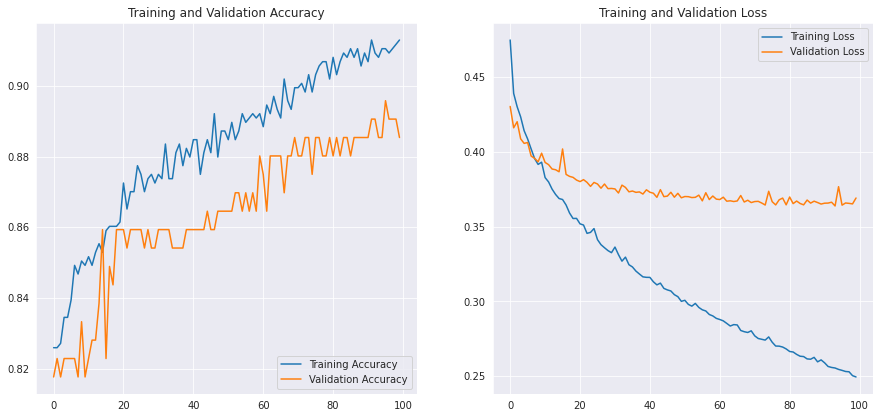

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
p_pred = resnet_model.predict(x_val)
p_pred = p_pred.reshape(1,-1)[0]
y_pred = np.where(p_pred > 0.5, 1, 0)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names = ['Batik Garutan','Batik Lain']))


6/6 [==============================] - 30s 5s/step
[[ 14  21]
 [  1 156]]
               precision    recall  f1-score   support

Batik Garutan       0.93      0.40      0.56        35
   Batik Lain       0.88      0.99      0.93       157

     accuracy                           0.89       192
    macro avg       0.91      0.70      0.75       192
 weighted avg       0.89      0.89      0.87       192



In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = keras.utils.load_img(path, target_size = (150,150))
  imgplot = plt.imshow(img)
  x = keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = resnet_model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(class_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print('Gambar ini termasuk kedalam class: ', class_list[j-1], classes)
      break